# Numerical Procedures

A derivative is a contract whose payoff depends on the value of some underlying asset. In cases where closed-form derivative pricing may be complex or even impossible, numerical procedures excel. A numerical procedure is the use of iterative computational methods in attempting to converge to a solution. One such basic implementation is a binomial tree. In a binomial tree, a node represents the state of an asset at a certain point of time associated with a price. Each node leads to two other nodes in the next time step. Similarly, in a trinomial tree, each node leads to three other nodes in the next time step. However, as the number of nodes or the time steps of trees increase, so do the computational resources consumed. Lattice pricing attempts to solve this problem by storing only the new information at each time step, while reusing values where possible.

In finite difference pricing, the nodes of the tree can also be represented as a grid. The terminal values on the grid consist of terminal conditions, while the edges of the grid represent boundary conditions in asset pricing. We will discuss the explicit method, implicit method, and the Crank-Nicolson method of the finite differences schemes to determine the price of an asset.

Although vanilla options and certain exotics such as European barrier options and lookback options can be found to have a closed-form solution, other exotic products such as Asian options do not contain a closed-form solution. In these cases, the pricing of options can be used with numerical procedures.

In this chapter, we will cover the following topics:

- Pricing European and American options using a binomial tree
- Using a Cox-Ross-Rubinstein (CRR) binomial tree
- Pricing options using a Leisen-Reimer (LR) tree
- Pricing options using a trinomial tree
- Pricing options using a binomial and trinomial lattice
- Deriving Greeks from a tree for free
- Finite differences with the explicit, implicit, and Crank-Nicolson method
- Implied volatility modelling using a LR tree and the bisection method

### Introduction to options

An option is a derivative of an asset that gives an owner the right but not the obligation to transact the underlying asset at a certain date for a certain price, known as the maturity date and strike price respectively.

A **call option** gives the buyer the right to buy an asset by a certain date for a certain price. A seller or writer of a call option is obligated to sell the underlying security to the buyer at the agreed price, should the buyer exercise his/her rights on the agreed date. A **put option** gives the buyer the right to sell the underlying asset by a certain date for a certain price. A seller or writer of a put option is obligated to buy the underlying security from the buyer at the agreed price, should the buyer exercise his/her rights on the agreed date.

The most common options available are the European options and American options. Other exotic options include Bermudan options and Asian options. This chapter will deal mainly with European and American options. An European option can only be exercised on the maturity date. An American option may be exercised at any time throughout the lifetime of the option.

### Binomial trees in options pricing

In the binomial options pricing model, the underlying security at one time period, represented as a node with a given price, is assumed to traverse to two other nodes in the next time step, representing an up state and a down state. Since options are derivatives of the underlying asset, the binomial pricing model tracks the underlying conditions on a discrete-time basis. Binomial option pricing can be used to value European options, American options, as well as Bermudan options.

The initial value of the root node is the spot price $S_0$ of the underlying security with a given probability of returns $p_u$ should its value increase, and a probability of loss $p_d$ should its value decrease. Based on these probabilities, the expected values of the security are calculated for each state of price increase or decrease for every time step. The terminal nodes represent every value of the expected security prices for every combination of up states and down states. We can then calculate the value of the option at every node, traverse the tree by risk-neutral expectations, and after discounting from the forward interest rates, we can derive the value of the call or put option.

### Pricing European options

Consider a two-step binomial tree. A non-dividend paying stock price starts at `$50`, and in each of the two time steps, the stock may go up by `20` percent or go down by `20` percent. We suppose that the risk-free rate is `5` percent per annum and the time to maturity $T$ is `0.5` years. We would like to find the value of an European put option with a strike price K of `$52`. The following figure shows the pricing of the stock using a binomial tree:

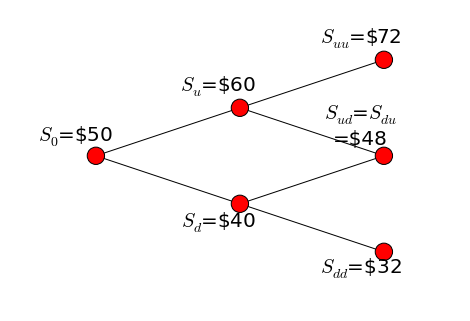

Here, the nodes are calculated as follows:

$$Spot \ Price, \ S_0 = 50$$

$$Probability \ of \ up \ state, \ p_u = 1.2$$

$$Probability \ of \ down \ state, \ p_d = 0.8$$

$$S_u = 50(1.2) = 60$$

$$S_d = 50(0.8) = 40$$

$$S_{uu} = 50(1.2)^2 = 72$$

$$S_{uu} = S_{ud} = 50(1.2)(0.8) = 48$$

$$S_{dd} = 50(0.8)^2 = 32$$

At the ultimate nodes, which hold the values of the underlying stock at maturity, the payoff from exercising an European call option is given as follows:

$$C_t = max(0, \ S_t - K)$$

In the case of an European put option, the payoff is as follows:

$$p_t = max(0, \ K - S_t)$$

From the option payoff values, we can then traverse the binomial tree backward to the current time and, after discounting from the risk-free rate, we will obtain our present value of the option. Traversing the tree backward takes into account the risk-neutral probabilities of the option's up states and down states.

We may assume that investors are indifferent to risk and that expected returns on all assets are equal. In the case of investing in stocks, by risk-neutral probability, the payoff from holding the stock, taking into account the up and down state possibilities, would be equal to the continuously compounded risk-free rate expected in the next time step, as follows:

$$e^{rt} = qu + (1-q)d$$

The risk-neutral probability $q$ of investing in the stock can be rewritten as follows:

$$q = \frac{e^{rt} - d}{u - d}$$

### Are these formulas relevant to stocks? What about futures?

Unlike investing in stocks, investors do not have to make an upfront payment to take a position in a futures contract. In a risk-neutral sense, the expected growth rate from holding a futures contract is zero and the payoff can be written as follows:

$$1 = qu + (1-q)d$$

The risk-neutral probability $q$ of investing in futures can be rewritten as follows:

$$q = \frac{1 - d}{u - d}$$

The risk-neutral probability $q$ of the stock given in the preceding example is calculated as `0.62817`, and the payoff of the put option is given as follows:

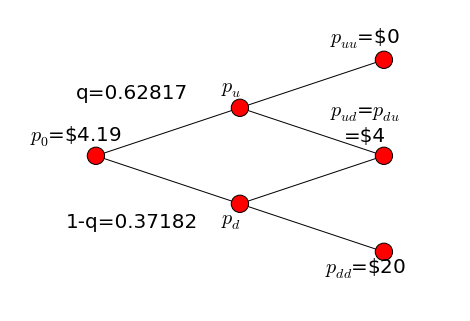

### Writing the StockOption class

Before going further in implementing the various pricing models that we are about to discuss, let's create a `StockOption` class to store and calculate the common attributes of the stock option that will be reused throughout this chapter. You can save the following code to a file named `StockOption.py`:

In [122]:
""" Store common attributes of a stock option """

import math

class StockOption(object):

    def __init__(self, S0, K, r, T, N, params):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1, N) # Ensure N have at least 1 time step
        self.STs = None # Declare the stock prices tree
        
        """ Optional parameters used by derived classes """
        self.pu = params.get("pu", 0) # Probability of up state
        self.pd = params.get("pd", 0) # Probability of down state
        self.div = params.get("div", 0) # Dividend yield
        self.sigma = params.get("sigma", 0) # Volatility
        self.is_call = params.get("is_call", True) # Call or put
        self.is_european = params.get("is_eu", True) # Eu or Am
        
        """ Computed values """
        self.dt = T/float(N) # Single time step, in years
        self.df = math.exp(
            -(r-self.div) * self.dt) # Discount factor

The current underlying price, strike price, risk-free rate, time to maturity, and number of time steps are compulsory common attributes for pricing options. The `params` variable is a dictionary object that accepts the required additional information pertaining to the model being used. From all of this information, the delta of the time step `dt` and the discount factor `df` are computed and can be reused throughout the pricing implementation.

### Writing the BinomialEuropeanOption class

The Python implementation of the binomial option pricing model of an European option is given as the `BinomialEuropeanOption` class, which inherits the common attributes of the option from the `StockOption` class.

The `price` method of the `BinomialEuropeanOption` class is a public method that is the entry point for all the instances of this class. It calls the` _setup_parameters_` method to set up the required model parameters, and then calls the ` _initialize_stock_price_tree_ ` method to simulate the expected values of the stock prices for the period up till $T$.

Finally, the `__begin_tree_traversal__` private method is called to initialize the payoff array and store the discounted payoff values, as it traverses the binomial tree back to the present time. The payoff tree nodes are returned as a NumPy array object, where the present value of the European option is found at the initial node.

Method names starting with double underlines `"__"` are private methods and can only be accessed within the same class. Method names starting with a single underline `"_"` are a protected method and may be overwritten by child classes. Method names not starting with an underline are public functions and may be accessed from any object.

Save this code to a file named `BinomialEuropeanOption.py`:

In [123]:
""" Price a European option by the binomial tree model """

from StockOption import StockOption
import math
import numpy as np

class BinomialEuropeanOption(StockOption):

    def __setup_parameters__(self):
        """ Required calculations for the model """
        self.M = self.N + 1 # Number of terminal nodes of tree
        self.u = 1 + self.pu # Expected value in the up state
        self.d = 1 - self.pd # Expected value in the down state
        self.qu = (math.exp((self.r-self.div)*self.dt) - self.d) / (self.u-self.d)
        self.qd = 1-self.qu
    
    def _initialize_stock_price_tree_(self):
        # Initialize terminal price nodes to zeros
        self.STs = np.zeros(self.M)
        
        # Calculate expected stock prices for each node
        for i in range(self.M):
            self.STs[i] = self.S0*(self.u**(self.N-i))*(self.d**i)
    
    def _initialize_payoffs_tree_(self):
        # Get payoffs when the option expires at terminal nodes
        payoffs = np.maximum(0, (self.STs-self.K) 
                             if self.is_call
                             else(self.K-self.STs))
        
        return payoffs
    
    def _traverse_tree_(self, payoffs):
        # Starting from the time the option expires, traverse
        # backwards and calculate discounted payoffs at each node
        for i in range(self.N):
            payoffs = (payoffs[:-1] * self.qu + payoffs[1:] * self.qd) * self.df
        
        return payoffs
    
    def __begin_tree_traversal__(self):
        payoffs = self._initialize_payoffs_tree_()
        return self._traverse_tree_(payoffs)
    
    def price(self):
        """ The pricing implementation """
        self.__setup_parameters__()
        self._initialize_stock_price_tree_()
        payoffs = self.__begin_tree_traversal__()
    
        return payoffs[0] # Option value converges to first node

Let's take the values from the two-step binomial tree example discussed earlier to price the European put option:

In [124]:
from StockOption import StockOption
from BinomialEuropeanOption import BinomialEuropeanOption

eu_option = BinomialEuropeanOption(50, 50, 0.05, 0.5, 2, {"pu": 0.2, "pd": 0.2, "is_call": False})

print (eu_option.price())

4.82565175126


Using the binomial option pricing model gives us a present value of `$4.826` for the European put option.

### Pricing American options with the BinomialTreeOption class

Unlike European options that can only be exercised at maturity, American options can be exercised at any time during their lifetime.

To implement the pricing of American options in Python, we do the same with the `BinomialEuropeanOption` class and create a class named `BinomialTreeOption`. The parameters used in the `_setup_parameters_` method remain the same with the removal of an unused `M` parameter. The various methods used in American options are as follows:

- `_initialize_stock_price_tree_`: This method uses a two-dimensional NumPy array to store the expected returns of the stock prices for all time steps. This information is used to calculate the payoff values from exercising the option at each period.
- `_initialize_payoffs_tree_`: This method creates the payoff tree as a two-dimensional NumPy array, starting with the intrinsic values of the option at maturity.
- `__check_early_exercise__`: This method is a private method that returns the maximum payoff values between exercising the American option early and not exercising the option at all.
- `_traverse_tree_`: This method now includes the invocation of the `__check_early_exercise__` method to check whether it is optimal to exercise an American option early at every time step.

Implementation of the `__begin_tree_traversal__` and the `price` methods remains the same.

The `BinomialTreeOption` class can now price both European and American options when the `is_eu` key of the `params` dictionary object is set to `true` or `false` respectively, when creating an instance of the class. Save the file as `BinomialAmericanOption.py` with the following code:

In [125]:
""" Price a European or American option by the binomial tree """
from StockOption import StockOption
import math
import numpy as np

class BinomialTreeOption(StockOption):
    def _setup_parameters_(self):
        self.u = 1 + self.pu # Expected value in the up state
        self.d = 1 - self.pd # Expected value in the down state
        self.qu = (math.exp((self.r-self.div)*self.dt) - self.d)/(self.u-self.d)
        self.qd = 1-self.qu
    
    def _initialize_stock_price_tree_(self):
        # Initialize a 2D tree at T=0
        self.STs = [np.array([self.S0])]
        
        # Simulate the possible stock prices path
        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate((prev_branches*self.u, [prev_branches[-1]*self.d]))
            self.STs.append(st) # Add nodes at each time step
    
    def _initialize_payoffs_tree_(self):
        # The payoffs when option expires
        return np.maximum(0, (self.STs[self.N]-self.K) 
                          if self.is_call
                          else (self.K-self.STs[self.N]))
    
    def __check_early_exercise__(self, payoffs, node):
        early_ex_payoff = (self.STs[node] - self.K)if self.is_call else (self.K - self.STs[node])
        
        return np.maximum(payoffs, early_ex_payoff)
    
    def _traverse_tree_(self, payoffs):
        for i in reversed(range(self.N)):
            # The payoffs from NOT exercising the option
            payoffs = (payoffs[:-1] * self.qu + payoffs[1:] * self.qd) * self.df
            
            # Payoffs from exercising, for American options
            if not self.is_european:
                payoffs = self.__check_early_exercise__(payoffs, i)
        
        return payoffs
    
    def __begin_tree_traversal__(self):
        payoffs = self._initialize_payoffs_tree_()
        return self._traverse_tree_(payoffs)
    
    def price(self):
        self._setup_parameters_()
        self._initialize_stock_price_tree_()
        payoffs = self.__begin_tree_traversal__()
        
        return payoffs[0]

Taking the same variables in the European put option pricing example, we can create an instance of the `BinomialTreeOption` class and price this American option:

In [126]:
from BinomialAmericanOption import BinomialTreeOption

am_option = BinomialTreeOption(50, 50, 0.05, 0.5, 2, {"pu": 0.2, "pd": 0.2, "is_call": False, "is_eu": False})

print (am_option.price())

5.11306008282


The American put option is priced at `$5.113`. Since American options can be exercised at any time and European options can only be exercised at maturity, this added flexibility of American options increases their value over European options in certain circumstances.

For American call options on an underlying asset that does not pay dividends, there might not be an extra value over its European call option counterpart. Because of the time value of money, it costs more to exercise the American call option today before the expiration at the strike price than at a future time with the same strike price. For an in-the-money American call option, exercising the option early loses the benefit of protection against adverse price movement below the strike price as well as its intrinsic time value. With no entitlement of dividend payments, there are no incentives to exercise American call options early.

### The Cox-Ross-Rubinstein model

In the preceding examples, we assumed that the underlying stock price would increase by `20` percent and decrease by `20` percent in its respective up state `u` and down state `d`. The **Cox-Ross-Rubinstein (CRR)** model proposes that, over a short period of time in the risk-neutral world, the binomial model matches the mean and variance of the underlying stock. The volatility of the underlying stock, or the standard deviation of returns of the stock, is taken into account as follows:

$$u = e^{\sigma \sqrt {\Delta t}}$$

$$d = \frac{1}{u} = e^{- \sigma \sqrt {\Delta t}}$$

### Writing the BinomialCRROption class

The implementation of the binomial CRR model remains the same as the binomial tree discussed earlier with the exception of the model parameters `u` and `d`.

In Python, we will create a class named `BinomialCRROption` and simply inherit the `BinomialTreeOption` class. Then, all that we need to do is to override the `_setup_parameters_` method with values from the CRR model.

Instances of the `BinomialCRROption` object will invoke the price method, which will call all other methods, except the overwritten `_setup_parameters_` method, of the parent `BinomialTreeOption` class.

Save the following code to a file named `BinomialCRROption.py`:

In [127]:
""" Price an option by the binomial CRR model """
from BinomialAmericanOption import BinomialTreeOption
import math

class BinomialCRROption(BinomialTreeOption):
    def _setup_parameters_(self):
        self.u = math.exp(self.sigma * math.sqrt(self.dt))
        self.d = 1./self.u
        self.qu = (math.exp((self.r-self.div)*self.dt) - self.d)/(self.u-self.d)
        self.qd = 1-self.qu

Consider again the two-step binomial tree. The non-dividend paying stock has a current price of `$50` and a volatility of `30` percent. Suppose that the risk-free rate is `5` percent per annum and the time to maturity $T$ is `0.5` years. We would like to find the value of an European put option with a strike price $K$ of `$50` by the CRR model:

In [128]:
from BinomialCRROption import BinomialTreeOption

eu_option = BinomialCRROption(50, 50, 0.05, 0.5, 2, {"sigma": 0.3, "is_call": False})

print ("European put: %s" % eu_option.price())

am_option = BinomialCRROption(50, 50, 0.05, 0.5, 2, {"sigma": 0.3, "is_call": False, "is_eu": False})

print ("American put: %s" % am_option.price())

European put: 3.1051473413
American put: 3.4091814964


### Using a Leisen-Reimer tree

In the binomial models discussed earlier, we made several assumptions on the probability of up and down states as well as the resulting risk-neutral probabilities. Besides the binomial model with CRR parameters discussed, other forms of parameterization discussed widely in mathematical finance include the Jarrow-Rudd parameterization, Tian parameterization, and Leisen-Reimer parameterization. Let's take a look at the Leisen-Reimer model in detail.

Dr. Dietmar Leisen and Matthias Reimer proposed a binomial tree model with the purpose of approximating to the Black-Scholes solution as the number of steps increases. It is known as the **Leisen-Reimer (LR)** tree, and the nodes do not recombine at every alternate step. It uses an inversion formula to achieve better accuracy during tree transversal.

A detailed explanation of the formulas is given in the paper *Binomial Models For Option Valuation - Examining And Improving Convergence*, March 1995, which is available at http://papers.ssrn.com/sol3/papers.cfm?abstract_id=5976.

We will be using method two of the Peizer and Pratt Inversion function $f$ with the following characteristic parameters:

$$f(z, \ j(n)) = 0.5 \mp \Bigg[ 0.25 - 0.25exp \Bigg\{ - \Bigg( \frac{z}{n + \frac{1}{3} + \frac{0.1}{n+1}} \Bigg) ^2 (n + \frac{1}{6}) \Bigg\} \Bigg] ^\frac{1}{2}$$

$$j(n) = \Bigg\{ \begin{align*} n, \ if n \ is \ even \\ n+1, \ if \ n \ is \ odd \end{align*}$$

$$p' = f(d_1, \ j(n))$$

$$p = f(d_2, \ j(n))$$

$$d_1 = \frac{log \bigg( \frac{S_0}{K} \bigg) + \bigg( \big( r - y \big) + \frac{\sigma^2}{2} \bigg) T}{\sigma \sqrt{T}}$$

$$d_2 = \frac{log \bigg( \frac{S_0}{K} \bigg) - \bigg( \big( r - y \big) + \frac{\sigma^2}{2} \bigg) T}{\sigma \sqrt{T}}$$

$$u = e^{(r-y) \Delta t \frac{p'}{p}}$$

$$d = \frac{e^{(r-y) \Delta t} - pu}{1 - p}$$

The parameter $S_0$ is the current stock price, $K$ is the strike price of the option, $\sigma$ is the annualized volatility of the underlying stock, $T$ is the time to maturity of the option, $r$ is the annualized risk-free rate, $y$ is the dividend yield, and $\Delta t$ is the time interval between each tree step.

### Writing the BinomialLROption class

The Python implementation of the Leisen-Reimer tree is given in the following `BinomialLROption` class. Similar to the `BinomialCRROption class`, we can inherit the `BinomialTreeOption` class and override the variables in the `_setup_parameters_` method with those of the LR tree model:

In [129]:
""" Price an option by the Leisen-Reimer tree """
from BinomialAmericanOption import BinomialTreeOption
import math

class BinomialLROption(BinomialTreeOption):
    def _setup_parameters_(self):
        odd_N = self.N if (self.N%2 == 1) else (self.N+1)
        d1 = (math.log(self.S0/self.K) + ((self.r-self.div) + (self.sigma**2)/2.) * self.T) / (self.sigma * math.sqrt(self.T))
        d2 = (math.log(self.S0/self.K) + ((self.r-self.div) - (self.sigma**2)/2.) * self.T) / (self.sigma * math.sqrt(self.T))
        pp_2_inversion = lambda z, n: .5 + math.copysign(1, z) * math.sqrt(.25 - .25 * math.exp(
            - ((z / (n + 1. / 3. + .1 / (n + 1))) **2.) * (n + 1. / 6.)))
        pbar = pp_2_inversion(d1, odd_N)
        
        self.p = pp_2_inversion(d2, odd_N)
        self.u = 1/self.df * pbar/self.p
        self.d = (1/self.df - self.p*self.u)/(1-self.p)
        self.qu = self.p
        self.qd = 1-self.p

Using the same examples as before, we can price the options using an LR tree:

In [130]:
from BinomialLROption import BinomialLROption

eu_option = BinomialLROption(50, 50, 0.05, 0.5, 3, {"sigma": 0.3, "is_call": False})

print ("European put: %s" % eu_option.price())

am_option = BinomialLROption(50, 50, 0.05, 0.5, 3, {"sigma": 0.3, "is_call": False, "is_eu": False})

print ("American put: %s" % am_option.price())

European put: 3.56742999918
American put: 3.66817910413


### The Greeks for free

In the binomial tree pricing models that we have covered so far, we traversed up and down the tree at each point in time to determine the node values. From the information at each node, we can reuse these computed values easily. One such use is the computation of Greeks.

The Greeks measures the sensitivities of the price of derivatives such as options with respect to changes in parameters of its underlying asset, often represented by Greek letters. In mathematical finance, the common names associated with Greeks include: alpha, beta, delta, gamma, vega, theta, and rho.

Two particularly useful Greeks for options are delta and gamma. Delta measures the sensitivity of the option price with respect to the underlying asset price. Gamma measures the rate of change in delta with respect to the underlying price.

As shown in the following figure, an additional layer of nodes is added around our original two-step tree to make it a four-step tree, which extends two steps backward in time. Even with additional terminal payoff nodes, all nodes will contain the same information as our original two-step tree. Our option value of interest is now located in the middle of the tree at `t=0`:

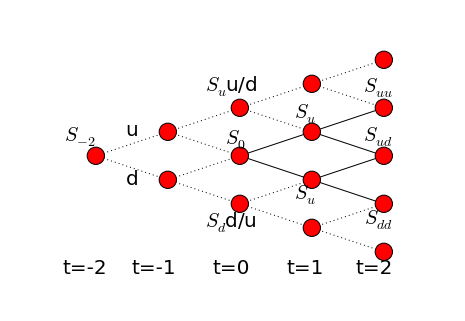

Notice that at `t=0` there exists two additional nodes' worth of information that we can use to compute the delta formula as follows:

$$delta = \frac{V_{up} - V_{down}}{S_0u \ / \ d-S_0d \ / \ u}$$

The delta formula states that the difference in the option prices in the up and down state is represented as a unit of the difference between the respective stock prices at time `t=0`.

Conversely, the gamma formula can be computed as follows:

$$gamma = \frac{\frac{V_{up} - V_0}{S_{0, \ up} - S_0} - \frac{V_0 - V_{down}}{S_0 - S_{0, \ down}}}{\frac{S_0 + S_{0, \ up}}{2} - \frac{S_0 + S_{0, \ down}}{2}}$$

The gamma formula states that the difference of deltas between the option prices in the up node and the down node against the initial node value are computed as a unit of the differences in price of the stock at the respective states.

### Writing the BinomialLRWithGreeks class

To illustrate the computation of Greeks with the LR tree, let's create a new class named `BinomialLRWithGreeks` that inherits the `BinomialLROption` class with our own implementation of the `price` method.

In the `price` method, we will start by calling the `_setup_parameters_` method of the parent class to initialize all variables required by the LR tree. However, this time we will also call the `__new_stock_price_tree__` method, which is a new private method specially used to create an extra layer of nodes around the original tree.

The `__begin_tree_traversal__` method is called to perform the usual LR tree implementation in the parent class. The returned NumPy array object now contains the information on the three nodes at `t=0`, where the middle node is the option price. The payoffs in the up and down states at `t=0` are in the first and last index of the array respectively.

With this information, the `price` method computes and returns the option price, and the delta and the gamma values together:

In [131]:
""" Compute option price, delta and gamma by the LR tree """
from BinomialLROption import BinomialLROption
import numpy as np

class BinomialLRWithGreeks(BinomialLROption):
    def __new_stock_price_tree__(self):
        """ Create additional layer of nodes to our original stock price tree """
        self.STs = [np.array([self.S0*self.u/self.d, self.S0, self.S0*self.d/self.u])]
    
        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate((prev_branches * self.u, [prev_branches[-1] * self.d]))
            self.STs.append(st)
    
    def price(self):
        self._setup_parameters_()
        self.__new_stock_price_tree__()
        payoffs = self.__begin_tree_traversal__()
        
        """ Option value is now in the middle node at t=0"""
        option_value = payoffs[len(payoffs)/2]
        if option_value % 2 != 0:
            return self[int(option_value - .5)]
        else:
            return (self[int(option_value)], self[int(option_value-1)])
        
        
        payoff_up = payoffs[0]
        payoff_down = payoffs[-1]
        S_up = self.STs[0][0]
        S_down = self.STs[0][-1]
        dS_up = S_up - self.S0
        dS_down = self.S0 - S_down
        
        """ Get delta value """
        dS = S_up - S_down
        dV = payoff_up - payoff_down
        delta = dV/dS
        
        """ Get gamma value """
        gamma = ((payoff_up-option_value)/dS_up - (option_value-payoff_down)/dS_down) / ((self.S0+S_up)/2. - (self.S0+S_down)/2.)

        return option_value, delta, gamma

Using the same example from the LR tree, we can compute the option values and Greeks for an European call and put option with `300` time steps:

In [132]:
from BinomialLRWithGreeks import BinomialLRWithGreeks

eu_call = BinomialLRWithGreeks(50, 50, 0.05, 0.5, 3, {"sigma": 0.3, "is_call": True})

results = eu_call.price()

print ("European call values")
print ("Price: %s\nDelta: %s\nGamma: %s" % results)

eu_put = BinomialLRWithGreeks(50, 50, 0.05, 0.5, 3, {"sigma":0.3, "is_call": False})

results = eu_put.price()

print ("European put values")
print ("Price: %s\nDelta: %s\nGamma: %s" % results)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

As shown from the `price` method and results, we managed to obtain additional information on Greeks from the modified binomial tree without any extra overhead in computational complexity.

### Trinomial trees in options pricing

In the binomial tree, each node leads to two other nodes in the next time step. Similarly in a trinomial tree, each node leads to three other nodes in the next time step. Besides having up and down states, the middle node of the trinomial tree indicates no change in state. When extended over more than two time steps, the trinomial tree can be thought of as a recombining tree, where the middle nodes always retain the same values as the previous time step.

Let's consider the Boyle trinomial tree, where the tree is calibrated such that the probability of up, down, and flat movements, $u$, $d$, and $m$ with risk-neutral probabilities $q_u$ , $q_d$ , and $q_m$ are as follows:

$$u = e^{\sigma \sqrt{2 \Delta t}}$$

$$d = \frac{1}{u} = e^{ - \sigma \sqrt{2 \Delta t}}$$

$$m = ud = 1$$

$$q_u = \Bigg( \frac{e^{(r-v)\frac{\Delta t}{2}} - e^\sigma \sqrt{\frac{\Delta t}{2}}}{e^\sigma \sqrt{\frac{\Delta t}{2}} - e^{-\sigma}\sqrt{\frac{\Delta t}{2}}}\Bigg) ^2$$

$$q_d = \Bigg( \frac{e^\sigma \sqrt{\frac{\Delta t}{2}} - e^{(r-v)\frac{\Delta t}{2}}}{e^\sigma \sqrt{\frac{\Delta t}{2}} - e^{- \sigma} \sqrt{\frac{\Delta t}{2}}}\Bigg) ^2$$

$$q_m = 1 - q_u - q_d$$

We can see that $ud = e^{\sigma \sqrt{2\Delta t}}e^{-\sigma \sqrt{2\Delta t}}$ recombines with $m = 1$. With calibration, the no state movement $m$ grows at a flat rate of `1` instead of at the risk-free rate. The variable $v$ is the annualized dividend yield and $\sigma$ is the annualized volatility of the underlying stock. In general, with an increased number of nodes to process, a trinomial tree gives better accuracy than the binomial tree when fewer time steps are modeled, saving on the computation speed and resources. Refer to the following figure:

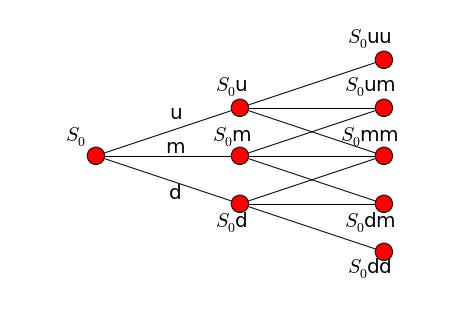

### Writing the TrinomialTreeOption class

The Python implementation of the trinomial tree is given in the following `TrinomialTreeOption` class, which inherits from the `BinomialTreeOption` class.

The `_setup_parameters_` method will implement the model parameters of the trinomial tree. The `_initialize_stock_price_tree_` method will set up the trinomial tree to include the flat movement of stock prices. The `_traverse_tree_` method takes into account the middle node after discounting the payoff. Save this file as `TrinomialTreeOption.py`:

In [133]:
""" Price an option by the Boyle trinomial tree """

from BinomialAmericanOption import BinomialTreeOption
import math
import numpy as np

class TrinomialTreeOption(BinomialTreeOption):
    def _setup_parameters_(self):
        """ Required calculations for the model """
        self.u = math.exp(self.sigma*math.sqrt(2.*self.dt))
        self.d = 1/self.u
        self.m = 1
        self.qu = ((math.exp((self.r-self.div) *
                             self.dt/2.) -
                    math.exp(-self.sigma *
                             math.sqrt(self.dt/2.))) /
                   (math.exp(self.sigma *
                             math.sqrt(self.dt/2.)) -
                    math.exp(-self.sigma *
                             math.sqrt(self.dt/2.))))**2
        self.qd = ((math.exp(self.sigma *
                             math.sqrt(self.dt/2.)) -
                    math.exp((self.r-self.div) *
                             self.dt/2.)) /
                   (math.exp(self.sigma *
                             math.sqrt(self.dt/2.)) -
                    math.exp(-self.sigma *
                             math.sqrt(self.dt/2.))))**2.
        
        self.qm = 1 - self.qu - self.qd
    
    def _initialize_stock_price_tree_(self):
        """ Initialize a 2D tree at t=0 """
        self.STs = [np.array([self.S0])]
        
        for i in range(self.N):
            prev_nodes = self.STs[-1]
            self.ST = np.concatenate(
                (prev_nodes*self.u, [prev_nodes[-1]*self.m,
                                     prev_nodes[-1]*self.d]))
            self.STs.append(self.ST)
    
    def _traverse_tree_(self, payoffs):
        """ Traverse the tree backwards """
        for i in reversed(range(self.N)):
            payoffs = (payoffs[:-2] * self.qu +
                       payoffs[1:-1] * self.qm +
                       payoffs[2:] * self.qd) * self.df
            
            if not self.is_european:
                payoffs = self.__check_early_exercise__(payoffs,
                                                        i)
        
        return payoffs

Using the same example of the binomial tree, we get the following result:

In [134]:
from TrinomialTreeOption import TrinomialTreeOption

eu_put = TrinomialTreeOption(50, 50, 0.05, 0.5, 2, {"sigma": 0.3, "is_call": False})

print ("European put: %s" % eu_put.price())

am_option = TrinomialTreeOption(50, 50, 0.05, 0.5, 2, {"sigma": 0.3, "is_call": False, "is_eu": False})

print ("American put: %s" % am_option.price())

European put: 3.33090549176
American put: 3.48241453902


We obtain prices of `$3.33` and `$3.48` for the European and American put option respectively.

### Lattices in options pricing

In binomial trees, each node recombines at every alternative node. In trinomial trees, each node recombines at every other node. This property of recombining trees can also be represented as lattices to help you save memory without recomputing and storing recombined nodes.

### Using a binomial lattice

We will create a binomial lattice from the binomial CRR tree since, at every alternate up and down nodes, the prices recombine to the same probability of $ud = 1$. In the following figure, $S_u$ and $S_d$ recombine with $S_{du} = S_{ud} = S_0$ . The tree can now be represented as a single list:

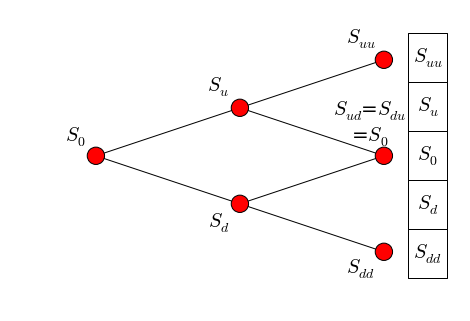

For a N-step binomial, a list of size $2N + 1$ is required to contain the information on the underlying stock prices. For European option pricing, the odd nodes of payoffs from the list represent the option value upon maturity. The tree traverses backward to obtain the option value. For American option pricing, as the tree traverses backward, both ends of the list shrink, and the odd nodes represent the associated stock prices for any time step. Payoffs from the earlier exercise can then be taken into account.

### Writing the BinomialCRROption class

Let's convert the binomial tree pricing into a lattice by CRR. We can inherit from the `BinomialCRROption` (which in turn inherits the `BinomialTreeOption` class) class and create a new class named `BinomialCRRLattice`. The following methods are overwritten with the implementation of the lattice while retaining the behavior of all the other pricing functions:

- `_setup_parameters_`: This method is overwritten to initialize the CRR parameters of the parent class as well as declaring the new variable $M$ as the list size.
- `_initialize_stock_price_tree_`: This method is overwritten to set up a one-dimensional NumPy array as the lattice with the size $M$.
- `_initialize_payoffs_tree_` and `__check_early_exercise__`: These methods are overwritten to take into account the payoffs at odd nodes only.

Save this code to a file named `BinomialCRRLattice.py`:

In [135]:
""" Price an option by the binomial CRR lattice """

from BinomialCRROption import BinomialCRROption
import numpy as np

class BinomialCRRLattice(BinomialCRROption):
    def _setup_parameters_(self):
        super(BinomialCRRLattice, self)._setup_parameters_()
        self.M = 2*self.N + 1
    
    def _initialize_stock_price_tree_(self):
        self.STs = np.zeros(self.M)
        self.STs[0] = self.S0 * self.u**self.N
        
        for i in range(self.M)[1:]:
            self.STs[i] = self.STs[i-1]*self.d
    
    def _initialize_payoffs_tree_(self):
        odd_nodes = self.STs[::2]
        return np.maximum(
            0, (odd_nodes - self.K) if self.is_call
            else(self.K - odd_nodes))
    
    def __check_early_exercise__(self, payoffs, node):
        self.STs = self.STs[1:-1] # Shorten the ends of the list
        odd_STs = self.STs[::2]
        early_ex_payoffs = (odd_STs-self.K) if self.is_call else (self.K-odd_STs)
        payoffs = np.maximum(payoffs, early_ex_payoffs)
        
        return payoffs

Using the same stock information from our binomial CRR model example, we can price an European and American put option using the binomial lattice pricing:

In [136]:
from BinomialCRRLattice import BinomialCRRLattice

eu_option = BinomialCRRLattice(50, 50, 0.05, 0.5, 2, {"sigma": 0.3, "is_call": False})

print ("European put: %s" % eu_option.price())

am_option = BinomialCRRLattice(50, 50, 0.05, 0.5, 2, {"sigma": 0.3, "is_call": False, "is_eu": False})

print ("American put: %s" % am_option.price())

European put: 3.1051473413
American put: 3.4091814964


### Using the trinomial lattice

The trinomial lattice works in very much the same way as the binomial lattice. Since each node recombines at every other node instead of alternate nodes, extracting odd nodes from the list is not necessary. As the size of the list is the same as the one in the binomial lattice, there are no extra storage requirements in trinomial lattice pricing, as explained in the following figure:

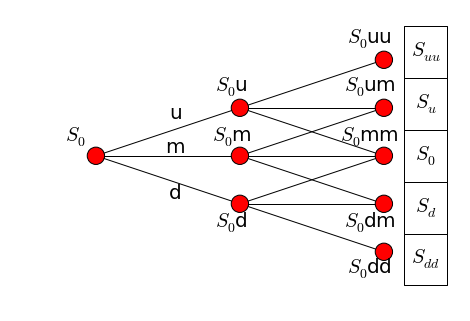

### Writing the TrinomialLattice class

In Python, let's create a class named `TrinomialLattice` for the trinomial lattice implementation that inherits from the `TrinomialTreeOption` class.

Just as we did for the `BinomialCRRLattice` class, the `_setup_parameters_`, `_initialize_stock_price_tree_`, `_initialize_payoffs_tree_`, and `__check_early_exercise__` methods are overwritten without having to take into account the  payoffs at odd nodes:

In [137]:
""" Price an option by the trinomial lattice """

from TrinomialTreeOption import TrinomialTreeOption
import numpy as np

class TrinomialLattice(TrinomialTreeOption):
    
    def _setup_parameters_(self):
        super(TrinomialLattice, self)._setup_parameters_()
        self.M = 2*self.N+1
    
    def _initialize_stock_price_tree_(self):
        self.STs = np.zeros(self.M)
        self.STs[0] = self.S0 * self.u**self.N
        
        for i in range(self.M)[1:]:
            self.STs[i] = self.STs[i-1]*self.d
    
    def _initialize_payoffs_tree_(self):
        return np.maximum(
            0, (self.STs-self.K) if self.is_call
            else(self.K-self.STs))
    
    def __check_early_exercise__(self, payoffs, node):
        self.STs = self.STs[1:-1] # Shorten the ends of the list
        early_ex_payoffs = (self.STs-self.K) if self.is_call else(self.K-self.STs)
        payoffs = np.maximum(payoffs, early_ex_payoffs)
        
        return payoffs

Using the same examples as before, we can price the European and American options using the trinomial lattice model:

In [138]:
from TrinomialLattice import TrinomialLattice

eu_option = TrinomialLattice(50, 50, 0.05, 0.5, 2, {"sigma": 0.3, "is_call":False})

print ("European put: %s" % eu_option.price())

am_option = TrinomialLattice(50, 50, 0.05, 0.5, 2, {"sigma": 0.3, "is_call": False, "is_eu": False})

print ("American put: %s" % am_option.price())

European put: 3.33090549176
American put: 3.48241453902


The output agrees with the results obtained from the trinomial tree option pricing model.

### Finite differences in options pricing

Finite difference schemes are very much similar to trinomial tree options pricing, where each node is dependent on three other nodes with an up movement, a down movement, and a flat movement. The motivation behind the finite differencing is the application of the **Black-Scholes Partial Differential Equation (PDE)** framework (involving functions and their partial derivatives) whose price $S(t)$ is a function of $f(S, \ t)$, with $r$ as the risk-free rate, $t$ as the time to maturity, and $\sigma$ as the volatility of the underlying security:

$$rf = \frac{df}{dt} + rS\frac{df}{dS} + \frac{1}{2}\sigma^2S^2\frac{d^2f}{dt^2}$$

The finite difference technique tends to converge faster than lattices and approximates complex exotic options very well.

To solve a PDE by finite differences working backward in time, a discrete-time grid of size $M$ by $N$ is set up to reflect asset prices over a course of time, such that $S$ and $t$ take on the following values at each point on the grid:

$$S = 0, \ dS, \ 2dS, \ 3dS, \ ..., \ (M - 1)dS, \ S_{max}$$

$$t = 0, \ dt, \ 2dt, \ 3dt, \ ..., \ (N - 1)dt, \ T$$

It follows that by grid notation, $f_{i, \ j} = f(idS, \ jdt)$. $S_{max}$ is a suitably large asset price that cannot be reached by the maturity time, $T$. $dS$ and $dt$ are thus intervals between each node in the grid, incremented by price and time respectively. The terminal condition at expiration time $T$ for every value of $S$ is $max(S − K, \ 0)$ for a call option with strike $K$ and $max(K − S, \ 0)$ for a put option. The grid traverses backward from the terminal conditions, complying with the PDE while adhering to the boundary conditions of the grid, such as the payoff from an early exercise.

The boundary conditions are defined values at the extreme ends of the nodes, where $i = 0$ and $i = N$ for every time at $t$. Values at the boundaries are used to calculate the values of all other lattice nodes iteratively using the PDE.

A visual representation of the grid is given by the following figure. As $i$ and $j$ increase from the top-left corner of the grid, the price $S$ tends toward $S_{max}$ (the maximum price possible) at the bottom-right corner of the grid:

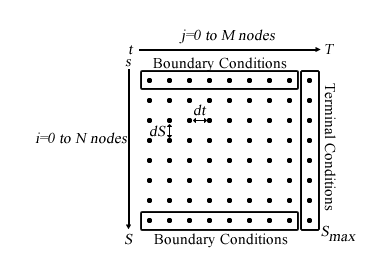

A number of ways to approximate the PDE are as follows:
- Forward difference: $$\frac{df}{dS} = \frac{f_{i + 1, \ j} - f_{i, \ j}}{dS}, \ \frac{df}{dt} = \frac{f_{i, \ j + 1} - f_{i, \ j}}{dt}$$
- Backward difference: $$\frac{df}{dS} = \frac{f_{i, \ j} - f_{i - 1, \ j}}{dS}, \ \frac{df}{dt} = \frac{f_{i, \ j} - f_{i, \ j - 1}}{dt}$$
- Central or symmetric difference: $$\frac{df}{dS} = \frac{f_{i + 1, \ j} - f_{i - 1, \ j}}{2dS}, \ \frac{df}{dt} = \frac{f_{i, \ j + 1} - f_{i, \ j - 1}}{2dt}$$
- The second derivative: $$\frac{d^2f}{dS^2} = \frac{f_{i + 1, \ j} - 2f_{i, \ j} + f_{i - 1, \ j}}{dS^2}$$

Once we have the boundary conditions set up, we can now apply an iterative approach using the explicit, implicit, or Crank-Nicolson method.

### The explicit method

The explicit method for approximating $f_{i, \ j}$ is given by:

$$rf_{i, \ j} = \frac{f_{i, \ j} - f_{i, \ j - 1}}{dt} + ridS\frac{f_{i + 1, \ j} - f_{i - 1, \ j}}{2dS} + \frac{1}{2}\sigma^2j^2\frac{f_{i + 1, \ j} + f_{i - 1, \ j}}{dS^2}$$

Here, it can be seen that the first difference is the backward difference with respect to $t$, the second difference is the central difference with respect to $S$, and the third difference is the second-order difference with respect to $S$. When we rearrange the terms, we have the following equation:

$$f_{i, \ j} = a_i^*f_{i - 1, \ j + 1} + b_i^*f_{i, \ j + 1} + c_i^*f_{i + 1, \ j + 1}$$

where $j = N − 1, \ N − 2, \ N − 3, \ ..., \ 2, \ 1, \ 0$ and $i = 1, \ 2, \ 3, \ ..., \ M − 2, \ M − 1$:

$$a_i^* = \frac{1}{2}dt\big( \sigma^2i^2 - ri\big) $$

$$b_i^* = 1 - dt\big( \sigma^2i^2 - ri\big) $$

$$c_i^* = \frac{1}{2}dt\big( \sigma^2i^2 + ri\big) $$

The iterative approach of the explicit method can be visually represented by the following figure:

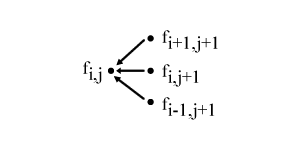

### Writing the FiniteDifferences class

As we will be writing the explicit, implicit, and Crank-Nicolson methods of finite differences in Python, let's write a parent class that can inherit the common properties and functions of all three methods.

We will create a class called `FiniteDifferences` that accepts and assigns all the required parameters in the `__init__ `constructor method and save it as `FiniteDifferences.py`.

The `price` method is the public method used for calling the specific finite difference scheme implementation. It will invoke these methods in the following order: `_setup_boundary_conditions`, `_setup_coefficients_`, `_traverse_grid_`, and `_interpolate_`. These methods are explained as follows:

- `_setup_boundary_conditions_`: This method sets up the boundary conditions of the grid structure as a NumPy two-dimensional array
- `_setup_coefficients_`: This method sets up the necessary coefficients used for traversing the grid structure
- `_traverse_grid_`: This method iterates the grid structure backward in time, storing the calculated values toward the first column of the grid
- `_interpolate_`: Using the final calculated values on the first column of the grid, this method will interpolate these values to find the option price that closely infers the initial stock price, $S0$

All of these methods are protected methods and may be overwritten by derived classes. The `pass` keyword simply does nothing; the derived classes will provide specific implementations of these functions:

In [139]:
""" Shared attributes and functions of FD """
import numpy as np

class FiniteDifferences(object):
    def __init__(self, S0, K, r, T, sigma, Smax, M, N,
                 is_call=True):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.Smax = Smax
        self.M, self.N = int(M), int(N) # Ensure M&N are integers
        self.is_call = is_call
        
        self.dS = Smax / float(self.M)
        self.dt = T / float(self.N)
        self.i_values = np.arange(self.M)
        self.j_values = np.arange(self.N)
        self.grid = np.zeros(shape=(self.M+1, self.N+1))
        self.boundary_conds = np.linspace(0, Smax, self.M+1)
    
    def _setup_boundary_conditions_(self):
        pass
    
    def _setup_coefficients_(self):
        pass
    
    def _traverse_grid_(self):
        """ Iterate the grid backwards in time """
        pass
    
    def _interpolate_(self):
        """
        Use piecewise linear interpolation on the initial
        grid column to get the closest price at S0.
        """
        return np.interp(self.S0,
                         self.boundary_conds,
                         self.grid[:, 0])
    
    def price(self):
        self._setup_boundary_conditions_()
        self._setup_coefficients_()
        self._traverse_grid_()
        return self._interpolate_()

### Writing the FDExplicitEu class

The Python implementation of finite differences by the explicit method is given in the following `FDExplicitEu` class, which inherits from the `FiniteDifferences` class and overrides the required implementation methods. Save this file as `FDExplicitEu.py`:

In [140]:
""" Explicit method of Finite Differences """
import numpy as np
from FiniteDifferences import FiniteDifferences

class FDExplicitEu(FiniteDifferences):
    def _setup_boundary_conditions_(self):
        if self.is_call:
            self.grid[:, -1] = np.maximum(
                self.boundary_conds - self.K, 0)
            self.grid[-1, :-1] = (self.Smax - self.K) * np.exp(-self.r *
                                                               self.dt *
                                                               (self.N-self.j_values))
        else:
            self.grid[:, -1] = np.maximum(self.K-self.boundary_conds, 0)
            self.grid[0, :-1] = (self.K - self.Smax) * np.exp(-self.r *
                                                              self.dt *
                                                              (self.N-self.j_values))
    
    def _setup_coefficients_(self):
        self.a = 0.5*self.dt*((self.sigma**2) *
                              (self.i_values**2) -
                              self.r*self.i_values)
        self.b = 1 - self.dt*((self.sigma**2) *
                              (self.i_values**2) +
                              self.r)
        self.c = 0.5*self.dt*((self.sigma**2) *
                              (self.i_values**2) +
                              self.r*self.i_values)
    
    def _traverse_grid_(self):
        for j in reversed(self.j_values):
            for i in range(self.M)[2:]:
                self.grid[i,j] = self.a[i]*self.grid[i-1,j+1] + self.b[i]*self.grid[i,j+1] + self.c[i]*self.grid[i+1,j+1]

On completion of traversing the grid structure, the first column contains the present value of the initial asset prices at $t = 0$. The `interp` function of NumPy is used to perform a linear interpolation to approximate the option value.

Besides using linear interpolation as the most common choice for the interpolation method, the other methods such as the spline or cubic may be used to approximate the option value.

Consider the example of an European put option. The underlying stock price is `$50` with a volatility of `40` percent. The strike price of the put option is `$50` with an expiration time of `5` months. The risk-free rate is `10` percent.

We can price the option using the explicit method with a $S_{max}$ value of `100`, an $M$ value of `1000`, and a $N$ value of `100`:

In [141]:
from FDExplicitEu import FDExplicitEu

option = FDExplicitEu(50, 50, 0.1, 5./12., 0.4, 100, 100, 1000, False)

print (option.price())

4.072882278148043


What happens when other values of $M$ and $N$ are chosen improperly?

In [142]:
option = FDExplicitEu(50, 50, 0.1, 5./12., 0.4, 100, 100, 100, False)

print (option.price())

-1.6291077072251005e+53


It appears that the explicit method of the finite difference scheme suffers from instability problems.

### The implicit method
The instability problem of the explicit method can be overcome using the forward difference with respect to time. The implicit method for approximating $f_{i, \ j}$ is given by:

$$rf_{i, \ j} = \frac{f_{i, \ j + 1} - f_{i, \ j}}{dt} + ridS\frac{f_{i + 1, \ j} - f_{i - 1, \ j}}{2dS} + \frac{1}{2}\sigma^2j^2\frac{f_{i + 1, \ j} - 2f_{i, \ j} + f_{i - 1, \ j}}{dS^2}$$

Here, it can be seen that the only difference between the implicit and explicit approximating scheme lies in the first difference, where the forward difference with respect to $t$ is used in the implicit scheme. When we rearrange the terms, we have the following expression:

$$f_{i, \ j + 1} = a_jf_{i - 1, \ j} + b_if_{i, \ j} + c_if_{i + 1, \ j}$$

Here, $j = N − 1, \ N − 2, \ ..., \ 2, \ 1, \ 0$ and $i = 1, \ 2, \ 3, \ ..., \ M − 1$

$$a_i = \frac{1}{2}\big( ridt - \sigma^2i^2dt\big) $$

$$b_i = 1 + \sigma^2i^2dt + rdt$$

$$c_i = -\frac{1}{2} + \big( ridt + \sigma^2i^2dt\big) $$

The iterative approach of the implicit scheme can be visually represented by the following figure:

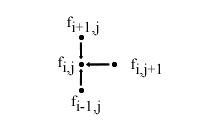

From the figure, it is intuitive to note that values of $j + 1$ are required to be computed before they can be used in the next iterative step, as the grid traverses backward. In the implicit scheme, the grid can be thought of as representing a system of linear equations at each iteration, as follows:

\begin{equation*}
\begin{vmatrix}
b_1 & c_1 & 0 & 0 & 0 & 0 \\
a_2 & b_2 & c_2 & 0 & 0 & 0 \\
0 & 0 & b_3 & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & a_{M - 2} & b_{M - 2} & c_{M - 2} \\
0 & 0 & 0 & 0 & a_{M - 1} & b_{M - 1}
\end{vmatrix}
\begin{vmatrix}
f_{1, \ j} \\
f_{2, \ j} \\
f_{3, \ j} \\
\vdots \\
f_{M - 2, \ j} \\
f_{M - 1, \ j}
\end{vmatrix} +
\begin{vmatrix}
a_1f_{0, \ j} \\
0 \\
0 \\
\vdots \\
0 \\
C_{M - 1}f_{M, \ j}
\end{vmatrix} = 
\begin{vmatrix}
f_{1, \ j + 1} \\
f_{2, \ j + 1} \\
f_{3, \ j + 1} \\
\vdots \\
f_{M - 2, \ j + 1} \\
f_{M - 1, \ j + 1}
\end{vmatrix}
\end{equation*}

By rearranging the terms, we get the following equation:

\begin{equation*}
\begin{vmatrix}
b_1 & c_1 & 0 & 0 & 0 & 0 \\
a_2 & b_2 & c_2 & 0 & 0 & 0 \\
0 & 0 & b_3 & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & a_{M - 2} & b_{M - 2} & c_{M - 2} \\
0 & 0 & 0 & 0 & a_{M - 1} & b_{M - 1}
\end{vmatrix}
\begin{vmatrix}
f_{1, \ j} \\
f_{2, \ j} \\
f_{3, \ j} \\
\vdots \\
f_{M - 2, \ j} \\
f_{M - 1, \ j}
\end{vmatrix} = 
\begin{vmatrix}
f_{1, \ j +1} \\
f_{2, \ j +1} \\
f_{3, \ j +1} \\
\vdots \\
f_{M - 2, \ j + 1} \\
f_{M - 1, \ j + 1}
\end{vmatrix} - 
\begin{vmatrix}
a_1f_{0, \ j} \\
0 \\
0 \\
\vdots \\
0 \\
C_{M - 1}f_{M, \ j}
\end{vmatrix}
\end{equation*}

The linear system of equations can be represented in the form of $Ax = B$, where we want to solve for values of $x$ in each iteration. Since the matrix $A$ is tri-diagonal, we can use the $LU$ factorization, where $A=LU$, for faster computation. Remember that we solved the linear system of equations using the $LU$ decomposition in *Chapter 2, The Importance of Linearity in Finance*.

### Writing the FDImplicitEu class

The Python implementation of the implicit scheme is given in the following `FDImplicitEu` class. We can inherit the implementation of the explicit method from the `FDExplicitEu` class discussed earlier and override the necessary methods of interest, namely the `_setup_coefficients_` and `_traverse_grid_` methods:

In [143]:
"""
Price a European option by the implicit method 
of finite differences.
"""
import numpy as np
import scipy.linalg as linalg
from FDExplicitEu import FDExplicitEu

class FDImplicitEu(FDExplicitEu):
    def _setup_coefficients_(self):
        self.a = 0.5*(self.r*self.dt*self.i_values -
                      (self.sigma**2)*self.dt*(self.i_values**2))
        self.b = 1 + (self.sigma**2)*self.dt*(self.i_values**2) + self.r*self.dt
        self.c = -0.5*(self.r * self.dt*self.i_values +
                       (self.sigma**2)*self.dt*(self.i_values**2))
        self.coeffs = np.diag(self.a[2:self.M], -1) + np.diag(self.b[1:self.M]) + np.diag(self.c[1:self.M-1], 1)
    
    def _traverse_grid_(self):
        """ Solve using linear systems of equations """
        P, L, U = linalg.lu(self.coeffs)
        aux = np.zeros(self.M-1)
        
        for j in reversed(range(self.N)):
            aux[0] = np.dot(-self.a[1], self.grid[0, j])
            x1 = linalg.solve(L, self.grid[1:self.M, j+1]+aux)
            x2 = linalg.solve(U, x1)
            self.grid[1:self.M, j] = x2

Using the same example as with the explicit scheme, we can price an European put option using the implicit scheme:

In [144]:
from FDImplicitEu import FDImplicitEu

option = FDImplicitEu(50, 50, 0.1, 5./12., 0.4, 100, 100, 100, False)

print (option.price())

option = FDImplicitEu(50, 50, 0.1, 5./12., 0.4, 100, 100, 1000, False)

print (option.price())

4.065801939431455
4.071594188049887


Given the current parameters and input data, it is observed that there are no stability issues with the implicit scheme.

### The Crank-Nicolson method

Another way of avoiding the instability issue, as seen in the explicit method, is to use the Crank-Nicolson method. The Crank-Nicolson method converges much more quickly using a combination of the explicit and implicit methods, taking the average of both. This leads us to the following equation:

$$\frac{1}{2}rf_{i, \ j-1}+\frac{1}{2}rf_{i, \ j}=\frac{f_{i, \ j}-f_{i, \ j-1}}{dt}\frac{1}{2}ridS\Bigg( \frac{f_{i+1, \ j-1}-f_{i-1, \ j-1}}{2dS}\Bigg) +\frac{1}{2}ridS\Bigg( \frac{f_{i+1, \ j}-f_{i-1, \ j}}{2dS}\Bigg) +\frac{1}{4}\sigma^2i^2dS^2\Bigg( \frac{f_{i+1, \ j-1}-2f_{i, \ j-1}+f_{i-1, \ j-1}}{dS^2}\Bigg) +\frac{1}{4}\sigma^2i^2dS^2\Bigg( \frac{f_{i+1, \ j}-2f_{i, \ j}+f_{i-1, \ j}}{dS^2}\Bigg)$$

This equation can also be rewritten as follows:

$$-\alpha_if_{i-1, \ j-1}+\big( 1-\beta_i\big) f_{i, \ j-1}-\gamma_if_{i+1, \ j-1}=\alpha_if_{i-1, \ j}+\big( 1-\beta_i\big) f_{i, \ j-1}-\gamma_if_{i+1, \ j}$$

Here:

$$\alpha_i=\frac{dt}{4}\big( \sigma^2i^2-ri\big) $$

$$\beta_i=\frac{dt}{2}\big( \sigma^2i^2+ri\big) $$

$$\gamma_i=\frac{dt}{4}\big( \sigma^2i^2+ri\big) $$

The iterative approach of the implicit scheme can be visually represented by the following figure:

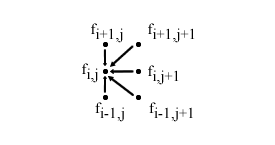

We can treat the equations as a system of linear equations in a matrix form:

$$M_1f_{j-1}=M_2f_j$$

Here:

\begin{equation*}
M_1=
\begin{vmatrix}
1-\beta_1 & -\gamma_1 & 0 & 0 & 0 & 0 \\
-\alpha_2 & 1-\beta_2 & -\gamma_2 & 0 & 0 & 0 \\
0 & -\alpha_3 & 1-\beta_3 & -\gamma_3 & 0 & 0 \\
0 & 0 & \ddots & \ddots & \ddots & 0 \\
0 & 0 & 0 & -\alpha_{M-2} & 1-\beta_{M-2} & 1-\gamma_{M-2} \\
0 & 0 & 0 & 0 & -\alpha_{M-1} & 1-\beta_{M-1}
\end{vmatrix}
\end{equation*}

\begin{equation*}
M_2=
\begin{vmatrix}
1+\beta_1 & \gamma_1 & 0 & 0 & 0 & 0 \\
\alpha_2 & 1+\beta_2 & \gamma_2 & 0 & 0 & 0 \\
0 & \alpha_3 & 1+\beta_3 & \gamma_3 & 0 & 0 \\
0 & 0 & \ddots & \ddots & \ddots & 0 \\
0 & 0 & 0 & \alpha_{M-2} & 1+\beta_{M-2} & 1+\gamma_{M-2} \\
0 & 0 & 0 & 0 & \alpha_{M-1} & 1+\beta_{M-1}
\end{vmatrix}
\end{equation*}

$$f_i = \big[ f_{1, \ j}, \ f_{2, \ j}, \ ..., \ f_{M1-1, \ j}\big] ^T$$

We can solve for the matrix $M$ on every iterative procedure.

### Writing the FDCnEu class

The Python implementation of the Crank-Nicolson method is given in the following `FDCnEu` class, which inherits from the `FDExplicitEu` class and overrides only the `_setup_coefficients_` and `_traverse_grid_` methods. Save this file as `FDCnEu.py`:

In [145]:
""" Crank-Nicolson method of Finite Differences """
import numpy as np
import scipy.linalg as linalg
from FDExplicitEu import FDExplicitEu

class FDCnEu(FDExplicitEu):
    def _setup_coefficients_(self):
        self.alpha = 0.25*self.dt*(
            (self.sigma**2)*(self.i_values**2) -
            self.r*self.i_values)
        self.beta = -self.dt*0.5*(
            (self.sigma**2)*(self.i_values**2) +
            self.r)
        self.gamma = 0.25*self.dt*(
            (self.sigma**2)*(self.i_values**2) +
            self.r*self.i_values)
        self.M1 = -np.diag(self.alpha[2:self.M], -1) + np.diag(1-self.beta[1:self.M]) - np.diag(self.gamma[1:self.M-1], 1)
        self.M2 = np.diag(self.alpha[2:self.M], -1) + np.diag(1+self.beta[1:self.M]) + np.diag(self.gamma[1:self.M-1], 1)
    
    def _traverse_grid_(self):
        """ Solve using linear systems of equations """
        P, L, U = linalg.lu(self.M1)
        
        for j in reversed(range(self.N)):
            x1 = linalg.solve(L,
                              np.dot(self.M2,
                                     self.grid[1:self.M, j+1]))
            x2 = linalg.solve(U, x1)
            self.grid[1:self.M, j] = x2

Using the same examples as with the explicit and implicit methods, we can price an European put option using the Crank-Nicolson method for different time point intervals:

In [146]:
from FDCnEu import FDCnEu

option = FDCnEu(50, 50, 0.1, 5./12., 0.4, 100, 100, 100, False)

print (option.price())

option = FDCnEu(50, 50, 0.1, 5./12., 0.4, 100, 100, 1000, False)

print (option.price())

4.072254507998115
4.072238354486825


From the observed values, the Crank-Nicolson method not only avoids the instability issue seen in the explicit scheme, but also converges faster than both the explicit and implicit methods. The implicit method requires more iterations, or bigger values of $N$, to produce values close to those of the Crank-Nicolson method.

### Pricing exotic barrier options

Finite differences are especially useful in pricing exotic options pricing. The nature of the option will dictate the specifications of the boundary conditions.

In this section, we will take a look at an example of pricing a down-and-out barrier option with the Crank-Nicolson method of finite differences. Due to its relative complexity, other analytical methods, such as Monte Carlo methods, are usually employed in favor of finite difference schemes.

### A down-and-out option

Let's take a look at an example of a down-and-out option. At any time during the life of the option, should the underlying asset price fall below a `Sbarrier` barrier price, the option is considered worthless. Since in the grid the finite difference scheme represents all the possible price points, we only need to consider nodes with the following price range:

$$S_{barrier}\leq S_t\leq S_{max}$$

We can then set up the boundary conditions as follows:

$$f\big( S_{max}, \ t\big) =0$$

$$f\big( S_{barrier}, \ t\big) =0$$

### Writing the FDCnDo class

Let's create a class named `FDCnDo` that inherits from the `FDCnEu` class we discussed earlier. We can take into account the barrier price in the constructor method, while leaving the rest of the Crank-Nicolson implementation in the `FDCnEu` class unchanged:

In [147]:
"""
Price a down-and-out option by the Crank-Nicolson
method of finite differences.
"""
import numpy as np
from FDCnEu import FDCnEu

class FDCnDo(FDCnEu):
    
    def __init__(self, S0, K, r, T, sigma, Sbarrier, Smax, M, N,
                 is_call=True):
        super(FDCnDo, self).__init__(
            S0, K, r, T, sigma, Smax, M, N, is_call)
        self.dS = (Smax-Sbarrier)/float(self.M)
        self.boundary_conds = np.linspace(Sbarrier,
                                          Smax,
                                          self.M+1)
        self.i_values = self.boundary_conds/self.dS

Consider an example of a down-and-out option. The underlying stock price is `$50` with a volatility of `40` percent. The strike price of the option is `$50` with an expiration time of `5` months. The risk-free rate is `10` percent. The barrier price is `$40`.

We can price a call option and a put down-and-out option with `Smax` as `100`, `M` as `120`, and `N` as `500`:

In [148]:
from FDCnDo import FDCnDo

option = FDCnDo(50, 50, 0.1, 5./12., 0.4, 40, 100, 120, 500)

print (option.price())

option = FDCnDo(50, 50, 0.1, 5./12., 0.4, 40, 100, 120, 500, False)

print (option.price())

5.49156055293478
0.5413635028954447


The prices of the down-and-out call and put options are `$5.4916` and `$0.5414` respectively.

### American options pricing with finite differences

So far, we have priced European options and exotic options. Due to the probability of an early exercise nature in American options, pricing such options is less straightforward. An iterative procedure is required in the implicit Crank-Nicolson method, where the payoffs from early exercises in the current period take into account the payoffs of an early exercise in the prior period. The Gauss-Siedel iterative method is proposed in the pricing of American options in the Crank-Nicolson method.

Remember in *Chapter 2, The Importance of Linearity in Finance*, we covered the Gauss-Siedel method of solving systems of linear equations in the form of $Ax=B$. Here, the matrix $A$ is decomposed into $A=L+U$, where $L$ is a lower triangular matrix and $U$ is an upper triangular matrix. Let's take a look at an example of a 4 by 4 matrix $A$:

\begin{equation*}
A =
\begin{vmatrix}
a & b & c & d \\
e & f & g & h \\
i & j & k & l \\
m & n & o & p
\end{vmatrix}=
\begin{vmatrix}
a & 0 & 0 & 0 \\
e & f & 0 & 0 \\
i & j & k & 0 \\
m & n & o & p
\end{vmatrix}+
\begin{vmatrix}
0 & b & c & d \\
0 & 0 & g & h \\
0 & 0 & 0 & l \\
0 & 0 & 0 & 0
\end{vmatrix}
\end{equation*}

The solution is then obtained iteratively as follows:

$$Ax=B$$

$$(L+U)x=B$$

$$Lx=B-Ux$$

$$x_{n+1} = L^{-1}(B-Ux)$$

We can adapt the Gauss-Siedel method to our Crank-Nicolson implementation as follows:

$$r_j=M_1f_{j-1}=M_2f_j+a_1\begin{vmatrix} f_{0, \ j-1}+f_{0, \ j} \\ 0 \\ \vdots \\ 0 \end{vmatrix}$$

This equation satisfies the early exercise privilege equation:

$$f_{i, \ j-1}=max\big( f_{i, \ j-1}, \ K-idS\big) $$

### Writing the FDCnAm class

Let's create a class named `FDCnAm` that inherits from the `FDCnEu` class, which is the Crank-Nicolson method's counterpart for pricing European options. The `_setup_coefficients_` method may be reused, while overriding all other methods for the inclusion of payoffs from an early exercise, if any:

In [149]:
""" Price an American option by the Crank-Nicolson method """
import numpy as np
import sys

from FDCnEu import FDCnEu

class FDCnAm(FDCnEu):
    
    def __init__(self, S0, K, r, T, sigma, Smax, M, N, omega, tol,
                 is_call=True):
        super(FDCnAm, self).__init__(
            S0, K, r, T, sigma, Smax, M, N, is_call)
        self.omega = omega
        self.tol = tol
        self.i_values = np.arange(self.M+1)
        self.j_values = np.arange(self.N+1)
    
    def _setup_boundary_conditions_(self):
        if self.is_call:
            self.payoffs = np.maximum(
                self.boundary_conds[1:self.M]-self.K, 0)
        else:
            self.payoffs = np.maximum(
                self.K-self.boundary_conds[1:self.M], 0)
        
        self.past_values = self.payoffs
        self.boundary_values = self.K * np.exp(-self.r *
                                               self.dt *
                                               (self.N-self.j_values))
    
    def _traverse_grid_(self):
        """ Solve using linear systems of equations """
        aux = np.zeros(self.M-1)
        new_values = np.zeros(self.M-1)
        
        for j in reversed(range(self.N)):
            aux[0] = self.alpha[1]*(self.boundary_values[j] +
                                    self.boundary_values[j+1])
            rhs = np.dot(self.M2, self.past_values) + aux
            old_values = np.copy(self.past_values)
            error = sys.float_info.max
            
            while self.tol < error:
                new_values[0] = max(self.payoffs[0],
                                    old_values[0] +
                                    self.omega/(1-self.beta[1]) *
                                    (rhs[0] -
                                     (1-self.beta[1])*old_values[0] +
                                     (self.gamma[1]*old_values[1])))
                for k in range(self.M-2)[1:]:
                    new_values[k] = max(self.payoffs[k],
                                        old_values[k] +
                                        self.omega/(1-self.beta[k+1]) *
                                        (rhs[k] +
                                         self.alpha[k+1]*new_values[k-1] -
                                         (1-self.beta[k+1])*old_values[k] +
                                         self.gamma[k+1]*old_values[k+1]))
                    
                    new_values[-1] = max(self.payoffs[-1],
                                         old_values[-1] +
                                         self.omega/(1-self.beta[-2]) *
                                         (rhs[-1] +
                                          self.alpha[-2]*new_values[-2] -
                                          (1-self.beta[-2])*old_values[-1]))
                    
                    error = np.linalg.norm(new_values - old_values)
                    old_values = np.copy(new_values)
                
                self.past_values = np.copy(new_values)
            
            self.values = np.concatenate(([self.boundary_values[0]],
                                          new_values,
                                          [0]))
        def _interpolate_(self):
            # Use linear interpolation on final values as 1D array
            return np.interp(self.S0,
                             self.boundary_conds,
                             self.values)

The tolerance parameter is used in the Gauss-Siedel method as the convergence criterion. The omega is the over-relaxation parameter. Higher omega values give faster convergence, but this also comes with higher possibilities of the algorithm not converging.

Let's price an American call-and-put option with an underlying asset price of `$50` and volatility of `40` percent, a strike price of `$50`, a risk-free rate of `10` percent, and an expiration date of `5` months. We choose a $Smax$ value of `100`, $M$ as `100`, $N$ as `42`, an omega parameter value of `1.2`, and a tolerance value of `0.001`:

In [152]:
from FDCnDo import FDCnDo
option = FDCnAm(50, 50, 0.1, 5./12., 0.4, 100, 100, 42, 1.2, 0.001)
print (option.price())

option = FDCnAm(50, 50, 0.1, 5./12., 0.4, 100, 100, 42, 1.2, 0.001, False)
print (option.price())

0.0
0.0


The prices of the call-and-put American stock options by the Crank-Nicolson method are `$6.109` and `$4.2778` respectively.

### Putting it all together – implied volatility modeling

In the options pricing methods we learned so far, a number of parameters are assumed to be constant: interest rates, strike prices, dividends, and volatility. Here, the parameter of interest is volatility. In quantitative research, the volatility ratio is used to forecast price trends.

To derive implied volatilities, we need to refer to *Chapter 3, Nonlinearity in Finance* where we discussed root-finding methods of nonlinear functions. We will use the bisection method of numerical procedures in our next example to create an implied volatility curve.

### Implied volatilities of AAPL American put option

Let's consider the option data of the stock Apple (AAPL) gathered at the end of day on October 3, 2014, given in the following table. The option expires on December 20, 2014. The prices listed are the mid-points of the bid and ask prices:

| Strike price | Call price | Put price |
|--------------|------------|-----------|
| 75           | 30         | 0.16      |
| 80           | 24.55      | 0.32      |
| 85           | 20.1       | 0.6       |
| 90           | 15.37      | 1.22      |
| 92.5         | 10.7       | 1.77      |
| 95           | 8.9        | 2.54      |
| 97.5         | 6.95       | 3.55      |
| 100          | 5.4        | 4.8       |
| 105          | 4.1        | 7.75      |
| 110          | 2.18       | 11.8      |
| 115          | 1.05       | 15.96     |
| 120          | 0.5        | 20.75     |
| 125          | 0.26       | 25.81     |

The last traded price of AAPL was `99.62` with an interest rate of `2.48` percent and a dividend yield of `1.82` percent. The American options expire in `78` days.

Using this information, let's create a new class named `ImpliedVolatilityModel` that accepts the stock option's parameters in the `__init__` constructor method. Import the `BinomialLROption` class that we created for the Leisen-Reimer binomial tree covered in the earlier section of this chapter. Also, import the `bisection.py` file that we created using the bisection function covered in *Chapter 3, Nonlinearity in Finance*.

The `_option_valuation_` method accepts the strike price $K$ and the volatility value `sigma` to compute the value of the option. In this example, we are using the `BinomialLROption` pricing method.

The `get_implied_volatilities` public method accepts a list of strike and option prices to compute the implied volatilities by the bisection method for every price available. Therefore, the length of the two lists must be the same.

The Python code for the `ImpliedVolatilityModel` is given as follows:

In [164]:
"""
Get implied volatilities from a Leisen-Reimer binomial
tree using the bisection method as the numerical procedure.
"""
from bisection import bisection
from BinomialLROption import BinomialLROption

class ImpliedVolatilityModel(object):
    
    def __init__(self, S0, r, T, div, N,
                 is_call=False):
        self.S0 = S0
        self.r = r
        self.T = T
        self.div = div
        self.N = N
        self.is_call = is_call
    def _option_valuation_(self, K, sigma):
        # Use the binomial Leisen-Reimer tree
        lr_option = BinomialLROption(
            self.S0, K, self.r, self.T, self.N,
            {"sigma": sigma,
             "is_call": self.is_call,
             "div": self.div})
        return lr_option.price()
    
    def get_implied_volatilities(self, Ks, opt_prices):
        impvols = []
        for i in range(len(Ks)):
            # Bind f(sigma) for use by the bisection method
            f = lambda sigma: self._option_valuation_(
                Ks[i], sigma) - opt_prices[i]
            impv = bisection(f, 0.01, 0.99, 0.0001, 100)[0]
            impvols.append(impv)
        return impvols 

Using this model, let's find out the implied volatilities of the American put options using this particular set of data:

In [165]:
# The data
strikes = [ 75, 80, 85, 90, 92.5, 95, 97.5, 100, 105, 110, 115, 120, 125]
put_prices = [0.16, 0.32, 0.6, 1.22, 1.77, 2.54, 3.55, 4.8, 7.75, 11.8, 15.96, 20.75, 25.81]

model = ImpliedVolatilityModel(99.62, 0.0248, 78/365., 0.0182, 77, is_call=False)
impvols_put = model.get_implied_volatilities(strikes, put_prices)

The implied volatility values are now stored in the `impvols_put` variable as a list object. Let's plot these values against the strike prices so that we can get an implied volatility curve:

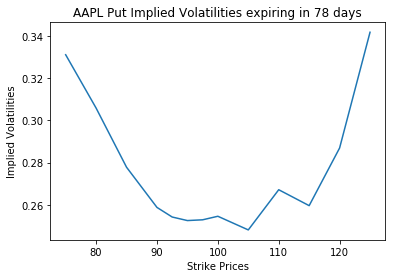

In [166]:
import matplotlib.pyplot as plt
plt.plot(strikes, impvols_put)
plt.xlabel('Strike Prices')
plt.ylabel('Implied Volatilities')
plt.title('AAPL Put Implied Volatilities expiring in 78 days')
plt.show()

Of course, pricing an option daily may not be ideal since markets change by fractions of a millisecond. We used the bisection method to solve the implied volatility as implied by the binomial tree, as opposed to the realized volatility values directly observed from market prices.

Should we fit this curve against a polynomial curve to identify potential arbitrage opportunities? Or extrapolate the curve to derive further insights on potential opportunities from implied volatilities of far out-of-the-money and in-the-money options? Well, these questions are for options traders like you to find out!

### Summary

In this chapter, we looked at a number of numerical procedures in derivative pricing the most common being options. One such procedure is the use of trees, with binomial trees being the simplest structure to model asset information, where one node extends to two other nodes in each time step, representing an up state and a down state respectively. In trinomial trees, each node extends to three other nodes in each time step, representing an up state, a down state, and a state with no movement respectively. As the tree traverses upwards, the underlying asset is computed and represented at each node. The option then takes on the structure of this tree and, starting from the terminal payoffs, the tree traverses backward and toward the root, which converges to the current discounted option price. Besides binomial and trinomial trees, trees can take on the form of the Cox-Ross-Rubinstein, Jarrow-Rudd, Tian, or Leisen-Reimer parameters.

By adding another layer of nodes around our tree, we introduced additional information from which we can derive the Greeks such as the delta and gamma without incurring additional computational cost.

Lattices were introduced as a way of saving storage costs over binomial and trinomial trees. In lattice pricing, nodes with new information are saved only once and reused later on nodes that require no change in the information.

We also discussed the finite difference schemes in option pricing, consisting of terminal and boundary conditions. From the terminal conditions, the grid traverses backward in time using the explicit method, implicit method, and the Crank-Nicolson method. Besides pricing European and American options, finite difference pricing schemes can be used to price exotic options, where we looked at an example of pricing a down-and-out barrier option.

By importing the bisection root-finding method learned in *Chapter 3, Nonlinearity in Finance* and the binomial Leisen-Reimer tree model in this chapter, we used market prices of an American option to create an implied volatility curve for further studies.

In the next chapter, we will take a look at working with interest rate instruments.